## CSC-180 Project 1
##### By: Derek Chen, Nicholas Gueliemo, Xai Yang, Katrina Yu

### Imports & Provided Functions from Lab

In [34]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        print('CLASS')
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        print('REG')
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Function to plot results
def plot(results):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for activation in results['Activation'].unique():
        subset = results[results['Activation'] == activation]
        ax.plot(subset['Neurons'].astype(str), subset['RMSE'], marker='o', label=activation)

    ax.set_title('Model Performance by Activation Function')
    ax.set_xlabel('Layer Configuration (Neurons)')
    ax.set_ylabel('RMSE')
    ax.legend(title='Activation Function')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    plt.plot(t['pred'].tolist(), label='Prediction', color='orange')
    plt.plot(t['y'].tolist(), label='Expected', color='blue')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


### Original Code
#### Includes:
- Spliting Data into Training & Testing for Models
- Using TF-IDF to extract features
- Implementing Early Stopping for training with TensorFlow
- Showing inital RMSE

In [35]:
# Original Code
# Author: Nicolas Gugliemo, Katrina Yu
# Date: 9/16/2024
# Project: Project 1 Yelp Business Rating Prediction using Tensorflow
# Goal: Predict Business's stars rating... 

# Set path and preprocess for functions
path = "./yelp_dataset/"
preprocess = True

#Set paths for JSON
review_Path = os.path.join(path,"yelp_academic_dataset_review.json")
business_Path = os.path.join(path,"yelp_academic_dataset_business.json")

# Read JSON data and drop businesses with less than 20 reviews
review_df = pd.read_json(review_Path, lines=True, nrows = 100000)
all_business_df = pd.read_json(business_Path, lines=True, nrows = 100000)
business_df = all_business_df[all_business_df['review_count'] >= 20]

# You may use the following code to group ALL the reviews by each business and create a new
# dataframe, where each line is a business with all its reviews aggregated together. From there,
# you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

# Create table with ID, stars, and all reviews in one table then change 'stars' since this is already a col on tfidf
business_subset = business_df[['business_id', 'stars']]
business_names = business_df[['name', 'business_id']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, review_subset, on='business_id', how='inner')
merged_df.rename(columns={'stars': 'stars_for_model'}, inplace=True)

# Initialize the tfidf Vectorizer and set max features and stop words
tfidf = TfidfVectorizer(max_features=4000,stop_words="english")

# Transform all_reviews and turn into a matrix
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Turn the matrix into a dataframe where the cols are all the words. Then add the stars into the dataframe for model to use and use to_xy for tensorflow to read
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df = pd.concat([merged_df['stars_for_model'], tfidf_df] , axis=1)
x,y = to_xy(tfidf_df,'stars_for_model')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Run the model 5 times to ensure best model is found
i = 0
while (i < 5):
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) 
    model.add(Dropout(0.1))
    model.add(Dense(25, input_dim=x.shape[1], activation='relu')) 
    model.add(Dense(1, activation='linear'))

    adam = optimizers.Adam(learning_rate=0.001, beta_1=0.999, beta_2=0.999, epsilon=None, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="dnn/yelp.keras", verbose=0, save_best_only=True) # save best model

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
    model.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size= 32, callbacks=[monitor,checkpointer], verbose=2, epochs=1000)
    i = i+1

model.load_weights('dnn/yelp.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)

score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE) without Rounding: {}".format(score))

# Rounding up predicted values to .5
for i in pred:
    if i[0] < 5:
        i[0] = round(i[0]*2)/2
    if i[0] > 5:
        i[0] = 5

score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE) with Rounding: {}".format(score))


REG


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 5s - 39ms/step - loss: 3.6573 - val_loss: 0.5117
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.4466 - val_loss: 0.3405
Epoch 3/1000
136/136 - 1s - 6ms/step - loss: 0.2906 - val_loss: 0.3411
Epoch 4/1000
136/136 - 1s - 6ms/step - loss: 0.2418 - val_loss: 0.3652
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.1986 - val_loss: 0.3762
Epoch 6/1000
136/136 - 1s - 4ms/step - loss: 0.1731 - val_loss: 0.3828
Epoch 7/1000
136/136 - 1s - 4ms/step - loss: 0.1393 - val_loss: 0.3901
Epoch 8/1000
136/136 - 1s - 5ms/step - loss: 0.1292 - val_loss: 0.4117
Epoch 9/1000
136/136 - 1s - 4ms/step - loss: 0.1091 - val_loss: 0.4069
Epoch 10/1000
136/136 - 1s - 4ms/step - loss: 0.1005 - val_loss: 0.4081
Epoch 11/1000
136/136 - 1s - 4ms/step - loss: 0.0932 - val_loss: 0.4205
Epoch 12/1000
136/136 - 1s - 5ms/step - loss: 0.0887 - val_loss: 0.4066
Epoch 12: early stopping
Epoch 1/1000
136/136 - 4s - 26ms/step - loss: 2.5016 - val_loss: 0.4381
Epoch 2/1000
136/136 - 1s - 6ms/step - loss: 0.

### Finding the best Model with the best RMSE
Testing with different combinations & numbers of the following:
- Activation: relu, sigmoid, tanh
- Number of layers and neuron count for each layer
- Optimizer: adam and sgd.

### & Displaying 5 different random businesses actual stars & predicted stars Using the best Model from above

REG


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 5s - 40ms/step - loss: 2.7346 - val_loss: 0.5290
Epoch 2/1000
136/136 - 1s - 5ms/step - loss: 0.4327 - val_loss: 0.3608
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.2911 - val_loss: 0.3583
Epoch 4/1000
136/136 - 1s - 5ms/step - loss: 0.2331 - val_loss: 0.3674
Epoch 5/1000
136/136 - 1s - 6ms/step - loss: 0.2144 - val_loss: 0.3991
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.1857 - val_loss: 0.4064
Epoch 7/1000
136/136 - 1s - 4ms/step - loss: 0.1692 - val_loss: 0.4110
Epoch 8/1000
136/136 - 1s - 4ms/step - loss: 0.1531 - val_loss: 0.4277
Epoch 9/1000
136/136 - 1s - 5ms/step - loss: 0.1421 - val_loss: 0.4377
Epoch 10/1000
136/136 - 1s - 5ms/step - loss: 0.1369 - val_loss: 0.4560
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.1302 - val_loss: 0.4584
Epoch 12/1000
136/136 - 1s - 5ms/step - loss: 0.1266 - val_loss: 0.4495
Epoch 13/1000
136/136 - 1s - 5ms/step - loss: 0.1220 - val_loss: 0.4496
Epoch 13: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[2.9047

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 8ms/step - loss: 1.6193 - val_loss: 0.6246
Epoch 2/1000
136/136 - 0s - 3ms/step - loss: 0.7126 - val_loss: 0.5926
Epoch 3/1000
136/136 - 0s - 3ms/step - loss: 0.6635 - val_loss: 0.5732
Epoch 4/1000
136/136 - 0s - 3ms/step - loss: 0.6198 - val_loss: 0.5220
Epoch 5/1000
136/136 - 0s - 3ms/step - loss: 0.5706 - val_loss: 0.4810
Epoch 6/1000
136/136 - 0s - 3ms/step - loss: 0.5229 - val_loss: 0.4361
Epoch 7/1000
136/136 - 0s - 3ms/step - loss: 0.4688 - val_loss: 0.3941
Epoch 8/1000
136/136 - 0s - 3ms/step - loss: 0.4307 - val_loss: 0.3617
Epoch 9/1000
136/136 - 0s - 3ms/step - loss: 0.3952 - val_loss: 0.3418
Epoch 10/1000
136/136 - 0s - 3ms/step - loss: 0.3701 - val_loss: 0.3269
Epoch 11/1000
136/136 - 0s - 3ms/step - loss: 0.3504 - val_loss: 0.3192
Epoch 12/1000
136/136 - 0s - 3ms/step - loss: 0.3395 - val_loss: 0.3198
Epoch 13/1000
136/136 - 0s - 4ms/step - loss: 0.3243 - val_loss: 0.3138
Epoch 14/1000
136/136 - 0s - 3ms/step - loss: 0.3101 - val_loss: 0.3105
Epoch 15/1000


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 3s - 23ms/step - loss: 2.9675 - val_loss: 0.4794
Epoch 2/1000
136/136 - 1s - 5ms/step - loss: 0.5818 - val_loss: 0.3633
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.4240 - val_loss: 0.3523
Epoch 4/1000
136/136 - 1s - 5ms/step - loss: 0.3773 - val_loss: 0.3593
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.3265 - val_loss: 0.3760
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.3094 - val_loss: 0.3947
Epoch 7/1000
136/136 - 1s - 5ms/step - loss: 0.2983 - val_loss: 0.3914
Epoch 8/1000
136/136 - 1s - 6ms/step - loss: 0.2709 - val_loss: 0.4111
Epoch 9/1000
136/136 - 1s - 6ms/step - loss: 0.2494 - val_loss: 0.4253
Epoch 10/1000
136/136 - 1s - 6ms/step - loss: 0.2292 - val_loss: 0.4091
Epoch 11/1000
136/136 - 1s - 6ms/step - loss: 0.2237 - val_loss: 0.4183
Epoch 12/1000
136/136 - 1s - 6ms/step - loss: 0.2161 - val_loss: 0.4143
Epoch 13/1000
136/136 - 1s - 5ms/step - loss: 0.2110 - val_loss: 0.4010
Epoch 13: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[2.7467315]
 [3.3625

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 11ms/step - loss: 1.7503 - val_loss: 0.6290
Epoch 2/1000
136/136 - 1s - 4ms/step - loss: 0.8030 - val_loss: 0.6072
Epoch 3/1000
136/136 - 1s - 4ms/step - loss: 0.7649 - val_loss: 0.5845
Epoch 4/1000
136/136 - 1s - 4ms/step - loss: 0.7031 - val_loss: 0.5464
Epoch 5/1000
136/136 - 1s - 4ms/step - loss: 0.6356 - val_loss: 0.5057
Epoch 6/1000
136/136 - 1s - 4ms/step - loss: 0.5845 - val_loss: 0.4449
Epoch 7/1000
136/136 - 1s - 4ms/step - loss: 0.5218 - val_loss: 0.4264
Epoch 8/1000
136/136 - 1s - 4ms/step - loss: 0.4620 - val_loss: 0.3607
Epoch 9/1000
136/136 - 1s - 4ms/step - loss: 0.4350 - val_loss: 0.3355
Epoch 10/1000
136/136 - 1s - 4ms/step - loss: 0.4000 - val_loss: 0.3431
Epoch 11/1000
136/136 - 1s - 4ms/step - loss: 0.3780 - val_loss: 0.3225
Epoch 12/1000
136/136 - 1s - 4ms/step - loss: 0.3648 - val_loss: 0.3206
Epoch 13/1000
136/136 - 1s - 4ms/step - loss: 0.3498 - val_loss: 0.3062
Epoch 14/1000
136/136 - 1s - 4ms/step - loss: 0.3461 - val_loss: 0.3078
Epoch 15/1000

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 3s - 26ms/step - loss: 2.8646 - val_loss: 0.5104
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.5705 - val_loss: 0.3693
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.4036 - val_loss: 0.3900
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.3501 - val_loss: 0.3861
Epoch 5/1000
136/136 - 1s - 6ms/step - loss: 0.3124 - val_loss: 0.3783
Epoch 6/1000
136/136 - 1s - 6ms/step - loss: 0.2854 - val_loss: 0.4076
Epoch 7/1000
136/136 - 1s - 6ms/step - loss: 0.2621 - val_loss: 0.4234
Epoch 8/1000
136/136 - 1s - 6ms/step - loss: 0.2516 - val_loss: 0.4059
Epoch 9/1000
136/136 - 1s - 6ms/step - loss: 0.2453 - val_loss: 0.4163
Epoch 10/1000
136/136 - 1s - 6ms/step - loss: 0.2144 - val_loss: 0.4095
Epoch 11/1000
136/136 - 1s - 6ms/step - loss: 0.2157 - val_loss: 0.4009
Epoch 12/1000
136/136 - 1s - 6ms/step - loss: 0.2094 - val_loss: 0.4116
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[2.7091982]
 [2.9948702]
 [2.4970171]
 ...
 [4.4752655]
 [3.6813874]
 [3.7860472]]
Score (RM

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 9ms/step - loss: 1.3980 - val_loss: 0.6166
Epoch 2/1000
136/136 - 1s - 4ms/step - loss: 0.7441 - val_loss: 0.5654
Epoch 3/1000
136/136 - 1s - 4ms/step - loss: 0.6676 - val_loss: 0.4997
Epoch 4/1000
136/136 - 1s - 4ms/step - loss: 0.5714 - val_loss: 0.4245
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.4857 - val_loss: 0.3904
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.4216 - val_loss: 0.3364
Epoch 7/1000
136/136 - 1s - 4ms/step - loss: 0.3927 - val_loss: 0.3550
Epoch 8/1000
136/136 - 0s - 4ms/step - loss: 0.3791 - val_loss: 0.4002
Epoch 9/1000
136/136 - 1s - 5ms/step - loss: 0.3567 - val_loss: 0.3047
Epoch 10/1000
136/136 - 1s - 4ms/step - loss: 0.3384 - val_loss: 0.3312
Epoch 11/1000
136/136 - 1s - 4ms/step - loss: 0.3412 - val_loss: 0.3041
Epoch 12/1000
136/136 - 1s - 4ms/step - loss: 0.3187 - val_loss: 0.2944
Epoch 13/1000
136/136 - 1s - 4ms/step - loss: 0.3176 - val_loss: 0.3082
Epoch 14/1000
136/136 - 1s - 4ms/step - loss: 0.3028 - val_loss: 0.2907
Epoch 15/1000


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 4s - 32ms/step - loss: 2.0802 - val_loss: 0.3827
Epoch 2/1000
136/136 - 1s - 6ms/step - loss: 0.3481 - val_loss: 0.3524
Epoch 3/1000
136/136 - 1s - 6ms/step - loss: 0.2553 - val_loss: 0.3745
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.2030 - val_loss: 0.3842
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.1682 - val_loss: 0.4093
Epoch 6/1000
136/136 - 1s - 6ms/step - loss: 0.1489 - val_loss: 0.4076
Epoch 7/1000
136/136 - 1s - 6ms/step - loss: 0.1390 - val_loss: 0.3982
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.1257 - val_loss: 0.3941
Epoch 9/1000
136/136 - 1s - 6ms/step - loss: 0.1119 - val_loss: 0.3892
Epoch 10/1000
136/136 - 1s - 6ms/step - loss: 0.1009 - val_loss: 0.4006
Epoch 11/1000
136/136 - 1s - 6ms/step - loss: 0.0998 - val_loss: 0.3948
Epoch 12/1000
136/136 - 1s - 6ms/step - loss: 0.0946 - val_loss: 0.3984
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[3.0702252]
 [3.6549942]
 [2.7401688]
 ...
 [4.904082 ]
 [3.6096969]
 [4.121092

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 10ms/step - loss: 1.4739 - val_loss: 0.6236
Epoch 2/1000
136/136 - 0s - 3ms/step - loss: 0.6982 - val_loss: 0.5983
Epoch 3/1000
136/136 - 0s - 3ms/step - loss: 0.6604 - val_loss: 0.5635
Epoch 4/1000
136/136 - 0s - 3ms/step - loss: 0.5935 - val_loss: 0.4884
Epoch 5/1000
136/136 - 0s - 3ms/step - loss: 0.5125 - val_loss: 0.4113
Epoch 6/1000
136/136 - 0s - 3ms/step - loss: 0.4349 - val_loss: 0.3549
Epoch 7/1000
136/136 - 1s - 4ms/step - loss: 0.3980 - val_loss: 0.3404
Epoch 8/1000
136/136 - 0s - 3ms/step - loss: 0.3717 - val_loss: 0.4617
Epoch 9/1000
136/136 - 0s - 3ms/step - loss: 0.3497 - val_loss: 0.3131
Epoch 10/1000
136/136 - 0s - 3ms/step - loss: 0.3231 - val_loss: 0.3415
Epoch 11/1000
136/136 - 0s - 3ms/step - loss: 0.3110 - val_loss: 0.3804
Epoch 12/1000
136/136 - 0s - 3ms/step - loss: 0.2986 - val_loss: 0.3249
Epoch 13/1000
136/136 - 1s - 4ms/step - loss: 0.2906 - val_loss: 0.3378
Epoch 14/1000
136/136 - 0s - 3ms/step - loss: 0.2814 - val_loss: 0.4093
Epoch 15/1000

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 4s - 32ms/step - loss: 3.0356 - val_loss: 0.3673
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.5883 - val_loss: 0.3723
Epoch 3/1000
136/136 - 1s - 8ms/step - loss: 0.4532 - val_loss: 0.3831
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.3795 - val_loss: 0.3576
Epoch 5/1000
136/136 - 1s - 8ms/step - loss: 0.3473 - val_loss: 0.3459
Epoch 6/1000
136/136 - 1s - 8ms/step - loss: 0.2909 - val_loss: 0.3403
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.2546 - val_loss: 0.3585
Epoch 8/1000
136/136 - 1s - 9ms/step - loss: 0.2317 - val_loss: 0.3233
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.2284 - val_loss: 0.3337
Epoch 10/1000
136/136 - 1s - 8ms/step - loss: 0.2053 - val_loss: 0.3356
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.2023 - val_loss: 0.3526
Epoch 12/1000
136/136 - 1s - 9ms/step - loss: 0.1936 - val_loss: 0.3583
Epoch 13/1000
136/136 - 1s - 10ms/step - loss: 0.1828 - val_loss: 0.3423
Epoch 14/1000
136/136 - 1s - 9ms/step - loss: 0.1776 - val_loss: 0.3349
Epoch 15/100

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 2s - 15ms/step - loss: 1.4839 - val_loss: 0.6919
Epoch 2/1000
136/136 - 1s - 4ms/step - loss: 0.7904 - val_loss: 0.6053
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.7088 - val_loss: 0.5320
Epoch 4/1000
136/136 - 1s - 4ms/step - loss: 0.5825 - val_loss: 0.7172
Epoch 5/1000
136/136 - 1s - 4ms/step - loss: 0.5180 - val_loss: 0.4220
Epoch 6/1000
136/136 - 1s - 6ms/step - loss: 0.4635 - val_loss: 0.3288
Epoch 7/1000
136/136 - 1s - 4ms/step - loss: 0.4262 - val_loss: 0.3383
Epoch 8/1000
136/136 - 1s - 5ms/step - loss: 0.4050 - val_loss: 0.4106
Epoch 9/1000
136/136 - 1s - 4ms/step - loss: 0.3682 - val_loss: 0.3835
Epoch 10/1000
136/136 - 1s - 4ms/step - loss: 0.3520 - val_loss: 0.2995
Epoch 11/1000
136/136 - 1s - 4ms/step - loss: 0.3514 - val_loss: 0.5252
Epoch 12/1000
136/136 - 1s - 4ms/step - loss: 0.3305 - val_loss: 0.3235
Epoch 13/1000
136/136 - 1s - 4ms/step - loss: 0.3101 - val_loss: 0.3227
Epoch 14/1000
136/136 - 1s - 7ms/step - loss: 0.2906 - val_loss: 0.2914


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 3s - 25ms/step - loss: 2.9064 - val_loss: 0.6313
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.7720 - val_loss: 0.5984
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.7065 - val_loss: 0.5580
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.6583 - val_loss: 0.5043
Epoch 5/1000
136/136 - 1s - 8ms/step - loss: 0.5914 - val_loss: 0.4469
Epoch 6/1000
136/136 - 1s - 8ms/step - loss: 0.5234 - val_loss: 0.3930
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.4650 - val_loss: 0.3576
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.4174 - val_loss: 0.3297
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.3822 - val_loss: 0.3153
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.3544 - val_loss: 0.3038
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.3347 - val_loss: 0.3011
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.3177 - val_loss: 0.2943
Epoch 13/1000
136/136 - 1s - 6ms/step - loss: 0.2941 - val_loss: 0.2917
Epoch 14/1000
136/136 - 1s - 5ms/step - loss: 0.2803 - val_loss: 0.2946


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 2s - 11ms/step - loss: 0.8887 - val_loss: 0.6455
Epoch 2/1000
136/136 - 0s - 3ms/step - loss: 0.7846 - val_loss: 0.6507
Epoch 3/1000
136/136 - 0s - 3ms/step - loss: 0.7690 - val_loss: 0.6493
Epoch 4/1000
136/136 - 0s - 3ms/step - loss: 0.7512 - val_loss: 0.6813
Epoch 5/1000
136/136 - 0s - 3ms/step - loss: 0.7488 - val_loss: 0.6495
Epoch 6/1000
136/136 - 0s - 3ms/step - loss: 0.7397 - val_loss: 0.6451
Epoch 7/1000
136/136 - 0s - 3ms/step - loss: 0.7429 - val_loss: 0.6642
Epoch 8/1000
136/136 - 0s - 3ms/step - loss: 0.7281 - val_loss: 0.6455
Epoch 9/1000
136/136 - 0s - 3ms/step - loss: 0.7235 - val_loss: 0.6510
Epoch 10/1000
136/136 - 0s - 3ms/step - loss: 0.7300 - val_loss: 0.6449
Epoch 11/1000
136/136 - 0s - 3ms/step - loss: 0.7269 - val_loss: 0.6592
Epoch 11: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[3.5969315]
 [3.6007435]
 [3.5961905]
 ...
 [3.5975163]
 [3.5997698]
 [3.5990732]]
Score (RMSE): 0.8030379414558411
Epoch 1/1000


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 3s - 23ms/step - loss: 2.1878 - val_loss: 0.6439
Epoch 2/1000
136/136 - 1s - 5ms/step - loss: 0.8256 - val_loss: 0.6403
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.8378 - val_loss: 0.6357
Epoch 4/1000
136/136 - 1s - 8ms/step - loss: 0.8205 - val_loss: 0.6227
Epoch 5/1000
136/136 - 1s - 8ms/step - loss: 0.7677 - val_loss: 0.5935
Epoch 6/1000
136/136 - 1s - 6ms/step - loss: 0.7102 - val_loss: 0.5131
Epoch 7/1000
136/136 - 1s - 5ms/step - loss: 0.5819 - val_loss: 0.3753
Epoch 8/1000
136/136 - 1s - 5ms/step - loss: 0.4537 - val_loss: 0.3236
Epoch 9/1000
136/136 - 1s - 5ms/step - loss: 0.4067 - val_loss: 0.3105
Epoch 10/1000
136/136 - 1s - 6ms/step - loss: 0.3785 - val_loss: 0.2993
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.3542 - val_loss: 0.3019
Epoch 12/1000
136/136 - 1s - 5ms/step - loss: 0.3357 - val_loss: 0.2880
Epoch 13/1000
136/136 - 1s - 5ms/step - loss: 0.3119 - val_loss: 0.2904
Epoch 14/1000
136/136 - 1s - 5ms/step - loss: 0.3024 - val_loss: 0.2953
Epoch 15/1000

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 2s - 11ms/step - loss: 1.4599 - val_loss: 0.6560
Epoch 2/1000
136/136 - 0s - 4ms/step - loss: 0.8258 - val_loss: 0.6461
Epoch 3/1000
136/136 - 0s - 4ms/step - loss: 0.7923 - val_loss: 0.6475
Epoch 4/1000
136/136 - 0s - 4ms/step - loss: 0.7839 - val_loss: 0.6527
Epoch 5/1000
136/136 - 0s - 4ms/step - loss: 0.7826 - val_loss: 0.6473
Epoch 6/1000
136/136 - 0s - 3ms/step - loss: 0.7518 - val_loss: 0.6457
Epoch 7/1000
136/136 - 0s - 3ms/step - loss: 0.7564 - val_loss: 0.6459
Epoch 8/1000
136/136 - 0s - 3ms/step - loss: 0.7554 - val_loss: 0.6467
Epoch 9/1000
136/136 - 0s - 3ms/step - loss: 0.7470 - val_loss: 0.6469
Epoch 10/1000
136/136 - 0s - 3ms/step - loss: 0.7392 - val_loss: 0.6559
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.7491 - val_loss: 0.6477
Epoch 12/1000
136/136 - 1s - 5ms/step - loss: 0.7387 - val_loss: 0.6493
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[[3.615553 ]
 [3.6158857]
 [3.6163473]
 ...
 [3.616393 ]
 [3.6153193]
 [3.616548 ]]
Score (RM

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 5s - 35ms/step - loss: 2.5007 - val_loss: 0.6464
Epoch 2/1000
136/136 - 2s - 13ms/step - loss: 0.8192 - val_loss: 0.6446
Epoch 3/1000
136/136 - 2s - 12ms/step - loss: 0.8233 - val_loss: 0.6418
Epoch 4/1000
136/136 - 1s - 10ms/step - loss: 0.8174 - val_loss: 0.6377
Epoch 5/1000
136/136 - 1s - 9ms/step - loss: 0.8065 - val_loss: 0.6294
Epoch 6/1000
136/136 - 1s - 9ms/step - loss: 0.7714 - val_loss: 0.5989
Epoch 7/1000
136/136 - 1s - 9ms/step - loss: 0.6865 - val_loss: 0.4515
Epoch 8/1000
136/136 - 1s - 8ms/step - loss: 0.4834 - val_loss: 0.3256
Epoch 9/1000
136/136 - 1s - 8ms/step - loss: 0.3897 - val_loss: 0.2993
Epoch 10/1000
136/136 - 1s - 8ms/step - loss: 0.3648 - val_loss: 0.2938
Epoch 11/1000
136/136 - 1s - 10ms/step - loss: 0.3298 - val_loss: 0.2905
Epoch 12/1000
136/136 - 1s - 9ms/step - loss: 0.3141 - val_loss: 0.2920
Epoch 13/1000
136/136 - 1s - 9ms/step - loss: 0.2942 - val_loss: 0.2887
Epoch 14/1000
136/136 - 1s - 8ms/step - loss: 0.2820 - val_loss: 0.2

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 10ms/step - loss: 1.1600 - val_loss: 0.6523
Epoch 2/1000
136/136 - 1s - 4ms/step - loss: 0.8028 - val_loss: 0.6471
Epoch 3/1000
136/136 - 1s - 4ms/step - loss: 0.7950 - val_loss: 0.6509
Epoch 4/1000
136/136 - 1s - 4ms/step - loss: 0.7985 - val_loss: 0.6458
Epoch 5/1000
136/136 - 1s - 4ms/step - loss: 0.7649 - val_loss: 0.6460
Epoch 6/1000
136/136 - 1s - 4ms/step - loss: 0.7576 - val_loss: 0.6457
Epoch 7/1000
136/136 - 1s - 4ms/step - loss: 0.7561 - val_loss: 0.6461
Epoch 8/1000
136/136 - 0s - 4ms/step - loss: 0.7391 - val_loss: 0.6456
Epoch 9/1000
136/136 - 0s - 3ms/step - loss: 0.7439 - val_loss: 0.6485
Epoch 10/1000
136/136 - 0s - 3ms/step - loss: 0.7492 - val_loss: 0.6541
Epoch 11/1000
136/136 - 1s - 4ms/step - loss: 0.7473 - val_loss: 0.6468
Epoch 12/1000
136/136 - 1s - 4ms/step - loss: 0.7325 - val_loss: 0.6465
Epoch 13/1000
136/136 - 1s - 4ms/step - loss: 0.7303 - val_loss: 0.6458
Epoch 14/1000
136/136 - 1s - 4ms/step - loss: 0.7444 - val_loss: 0.6460
Epoch 14: ear

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 4s - 26ms/step - loss: 1.1680 - val_loss: 0.6352
Epoch 2/1000
136/136 - 1s - 5ms/step - loss: 0.7408 - val_loss: 0.6165
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.6741 - val_loss: 0.4901
Epoch 4/1000
136/136 - 1s - 5ms/step - loss: 0.4792 - val_loss: 0.3360
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.3676 - val_loss: 0.3159
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.3257 - val_loss: 0.3103
Epoch 7/1000
136/136 - 1s - 6ms/step - loss: 0.3036 - val_loss: 0.2882
Epoch 8/1000
136/136 - 1s - 6ms/step - loss: 0.2737 - val_loss: 0.2882
Epoch 9/1000
136/136 - 1s - 5ms/step - loss: 0.2580 - val_loss: 0.3065
Epoch 10/1000
136/136 - 1s - 6ms/step - loss: 0.2493 - val_loss: 0.2897
Epoch 11/1000
136/136 - 1s - 6ms/step - loss: 0.2320 - val_loss: 0.3048
Epoch 12/1000
136/136 - 1s - 6ms/step - loss: 0.2243 - val_loss: 0.2931
Epoch 13/1000
136/136 - 1s - 6ms/step - loss: 0.2137 - val_loss: 0.3282
Epoch 14/1000
136/136 - 1s - 5ms/step - loss: 0.2066 - val_loss: 0.2994
Epoch 15/1000

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 2s - 13ms/step - loss: 0.8899 - val_loss: 0.6486
Epoch 2/1000
136/136 - 1s - 5ms/step - loss: 0.7664 - val_loss: 0.6675
Epoch 3/1000
136/136 - 1s - 4ms/step - loss: 0.7620 - val_loss: 0.7033
Epoch 4/1000
136/136 - 1s - 4ms/step - loss: 0.7465 - val_loss: 0.6689
Epoch 5/1000
136/136 - 1s - 4ms/step - loss: 0.7455 - val_loss: 0.6523
Epoch 6/1000
136/136 - 1s - 4ms/step - loss: 0.7399 - val_loss: 0.6458
Epoch 7/1000
136/136 - 1s - 4ms/step - loss: 0.7366 - val_loss: 0.6474
Epoch 8/1000
136/136 - 1s - 4ms/step - loss: 0.7312 - val_loss: 0.6466
Epoch 9/1000
136/136 - 1s - 4ms/step - loss: 0.7306 - val_loss: 0.6595
Epoch 10/1000
136/136 - 1s - 4ms/step - loss: 0.7314 - val_loss: 0.6557
Epoch 11/1000
136/136 - 0s - 4ms/step - loss: 0.7203 - val_loss: 0.6501
Epoch 12/1000
136/136 - 0s - 3ms/step - loss: 0.7248 - val_loss: 0.6582
Epoch 13/1000
136/136 - 1s - 4ms/step - loss: 0.7181 - val_loss: 0.6469
Epoch 14/1000
136/136 - 1s - 4ms/step - loss: 0.7208 - val_loss: 0.6855
Epoch 15/1000

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 7s - 50ms/step - loss: 2.0000 - val_loss: 0.6474
Epoch 2/1000
136/136 - 1s - 9ms/step - loss: 0.8448 - val_loss: 0.6457
Epoch 3/1000
136/136 - 1s - 9ms/step - loss: 0.8183 - val_loss: 0.6459
Epoch 4/1000
136/136 - 1s - 8ms/step - loss: 0.8120 - val_loss: 0.6457
Epoch 5/1000
136/136 - 1s - 8ms/step - loss: 0.8189 - val_loss: 0.6456
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.8204 - val_loss: 0.6487
Epoch 7/1000
136/136 - 1s - 8ms/step - loss: 0.8057 - val_loss: 0.6456
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.7893 - val_loss: 0.6532
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.8236 - val_loss: 0.6445
Epoch 10/1000
136/136 - 1s - 8ms/step - loss: 0.7757 - val_loss: 0.6297
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.5826 - val_loss: 0.3420
Epoch 12/1000
136/136 - 1s - 8ms/step - loss: 0.4039 - val_loss: 0.3090
Epoch 13/1000
136/136 - 1s - 9ms/step - loss: 0.3477 - val_loss: 0.2967
Epoch 14/1000
136/136 - 1s - 8ms/step - loss: 0.3396 - val_loss: 0.2944


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 2s - 14ms/step - loss: 1.0978 - val_loss: 0.6506
Epoch 2/1000
136/136 - 1s - 4ms/step - loss: 0.7830 - val_loss: 0.6516
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.8037 - val_loss: 0.6458
Epoch 4/1000
136/136 - 1s - 6ms/step - loss: 0.7759 - val_loss: 0.6479
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.7713 - val_loss: 0.6471
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.7544 - val_loss: 0.6600
Epoch 7/1000
136/136 - 1s - 5ms/step - loss: 0.7582 - val_loss: 0.6457
Epoch 8/1000
136/136 - 1s - 5ms/step - loss: 0.7481 - val_loss: 0.6476
Epoch 9/1000
136/136 - 1s - 6ms/step - loss: 0.7471 - val_loss: 0.6466
Epoch 10/1000
136/136 - 1s - 5ms/step - loss: 0.7375 - val_loss: 0.6458
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.7402 - val_loss: 0.6470
Epoch 12/1000
136/136 - 1s - 4ms/step - loss: 0.7361 - val_loss: 0.6507
Epoch 13/1000
136/136 - 1s - 4ms/step - loss: 0.7361 - val_loss: 0.6457
Epoch 13: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[3.6087

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 5s - 35ms/step - loss: 1.6339 - val_loss: 0.4359
Epoch 2/1000
136/136 - 1s - 5ms/step - loss: 0.3806 - val_loss: 0.3250
Epoch 3/1000
136/136 - 1s - 4ms/step - loss: 0.2696 - val_loss: 0.3353
Epoch 4/1000
136/136 - 1s - 4ms/step - loss: 0.2176 - val_loss: 0.3658
Epoch 5/1000
136/136 - 1s - 4ms/step - loss: 0.2003 - val_loss: 0.3735
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.1836 - val_loss: 0.4021
Epoch 7/1000
136/136 - 1s - 5ms/step - loss: 0.1678 - val_loss: 0.4227
Epoch 8/1000
136/136 - 1s - 5ms/step - loss: 0.1557 - val_loss: 0.4380
Epoch 9/1000
136/136 - 1s - 5ms/step - loss: 0.1445 - val_loss: 0.4509
Epoch 10/1000
136/136 - 1s - 6ms/step - loss: 0.1346 - val_loss: 0.4536
Epoch 11/1000
136/136 - 1s - 6ms/step - loss: 0.1304 - val_loss: 0.4736
Epoch 12/1000
136/136 - 1s - 6ms/step - loss: 0.1237 - val_loss: 0.4741
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[2.3287964]
 [3.4296145]
 [2.5494347]
 ...
 [4.421252 ]
 [3.6800194]
 [3.877599 ]]
Score (RM

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 2s - 12ms/step - loss: 1.1019 - val_loss: 0.6011
Epoch 2/1000
136/136 - 0s - 3ms/step - loss: 0.6610 - val_loss: 0.5491
Epoch 3/1000
136/136 - 0s - 3ms/step - loss: 0.5946 - val_loss: 0.4969
Epoch 4/1000
136/136 - 0s - 3ms/step - loss: 0.5284 - val_loss: 0.4423
Epoch 5/1000
136/136 - 0s - 3ms/step - loss: 0.4733 - val_loss: 0.3914
Epoch 6/1000
136/136 - 0s - 3ms/step - loss: 0.4161 - val_loss: 0.3719
Epoch 7/1000
136/136 - 0s - 3ms/step - loss: 0.3731 - val_loss: 0.3336
Epoch 8/1000
136/136 - 0s - 3ms/step - loss: 0.3490 - val_loss: 0.3191
Epoch 9/1000
136/136 - 0s - 3ms/step - loss: 0.3332 - val_loss: 0.3471
Epoch 10/1000
136/136 - 0s - 3ms/step - loss: 0.3145 - val_loss: 0.3064
Epoch 11/1000
136/136 - 0s - 3ms/step - loss: 0.3078 - val_loss: 0.3013
Epoch 12/1000
136/136 - 0s - 3ms/step - loss: 0.2963 - val_loss: 0.2999
Epoch 13/1000
136/136 - 1s - 4ms/step - loss: 0.2866 - val_loss: 0.2969
Epoch 14/1000
136/136 - 1s - 4ms/step - loss: 0.2775 - val_loss: 0.3625


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 4s - 31ms/step - loss: 1.3984 - val_loss: 0.3497
Epoch 2/1000
136/136 - 1s - 6ms/step - loss: 0.3936 - val_loss: 0.3099
Epoch 3/1000
136/136 - 1s - 6ms/step - loss: 0.3462 - val_loss: 0.3185
Epoch 4/1000
136/136 - 1s - 6ms/step - loss: 0.2915 - val_loss: 0.3354
Epoch 5/1000
136/136 - 1s - 6ms/step - loss: 0.2434 - val_loss: 0.3455
Epoch 6/1000
136/136 - 1s - 6ms/step - loss: 0.2303 - val_loss: 0.3700
Epoch 7/1000
136/136 - 1s - 6ms/step - loss: 0.2107 - val_loss: 0.3915
Epoch 8/1000
136/136 - 1s - 6ms/step - loss: 0.1937 - val_loss: 0.3852
Epoch 9/1000
136/136 - 1s - 9ms/step - loss: 0.1874 - val_loss: 0.4103
Epoch 10/1000
136/136 - 1s - 6ms/step - loss: 0.1706 - val_loss: 0.4236
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.1652 - val_loss: 0.4215
Epoch 12/1000
136/136 - 1s - 6ms/step - loss: 0.1605 - val_loss: 0.4443
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[2.435897 ]
 [3.5279489]
 [2.4798317]
 ...
 [4.4080253]
 [3.1626058]
 [3.864017

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 2s - 14ms/step - loss: 1.0863 - val_loss: 0.6191
Epoch 2/1000
136/136 - 1s - 5ms/step - loss: 0.7186 - val_loss: 0.5723
Epoch 3/1000
136/136 - 1s - 4ms/step - loss: 0.6650 - val_loss: 0.5150
Epoch 4/1000
136/136 - 1s - 4ms/step - loss: 0.5565 - val_loss: 0.4188
Epoch 5/1000
136/136 - 1s - 4ms/step - loss: 0.4608 - val_loss: 0.3826
Epoch 6/1000
136/136 - 1s - 6ms/step - loss: 0.4060 - val_loss: 0.3448
Epoch 7/1000
136/136 - 1s - 5ms/step - loss: 0.3771 - val_loss: 0.4258
Epoch 8/1000
136/136 - 1s - 6ms/step - loss: 0.3585 - val_loss: 0.3077
Epoch 9/1000
136/136 - 1s - 6ms/step - loss: 0.3410 - val_loss: 0.3108
Epoch 10/1000
136/136 - 1s - 8ms/step - loss: 0.3282 - val_loss: 0.4292
Epoch 11/1000
136/136 - 1s - 4ms/step - loss: 0.3115 - val_loss: 0.3141
Epoch 12/1000
136/136 - 0s - 4ms/step - loss: 0.3006 - val_loss: 0.3829
Epoch 13/1000
136/136 - 1s - 4ms/step - loss: 0.2901 - val_loss: 0.3047
Epoch 14/1000
136/136 - 0s - 3ms/step - loss: 0.2712 - val_loss: 0.2966


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 4s - 27ms/step - loss: 1.2875 - val_loss: 0.3604
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.3883 - val_loss: 0.3247
Epoch 3/1000
136/136 - 1s - 6ms/step - loss: 0.3041 - val_loss: 0.3373
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.2576 - val_loss: 0.3644
Epoch 5/1000
136/136 - 1s - 6ms/step - loss: 0.2343 - val_loss: 0.3655
Epoch 6/1000
136/136 - 1s - 6ms/step - loss: 0.2056 - val_loss: 0.3872
Epoch 7/1000
136/136 - 1s - 6ms/step - loss: 0.1899 - val_loss: 0.4200
Epoch 8/1000
136/136 - 1s - 6ms/step - loss: 0.1903 - val_loss: 0.4088
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.1699 - val_loss: 0.4000
Epoch 10/1000
136/136 - 1s - 6ms/step - loss: 0.1529 - val_loss: 0.4283
Epoch 11/1000
136/136 - 1s - 6ms/step - loss: 0.1470 - val_loss: 0.4324
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.1401 - val_loss: 0.4284
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[2.8956559]
 [3.394457 ]
 [2.851372 ]
 ...
 [4.6446958]
 [3.688556 ]
 [4.118449

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 11ms/step - loss: 1.0024 - val_loss: 0.6108
Epoch 2/1000
136/136 - 1s - 4ms/step - loss: 0.6911 - val_loss: 0.5329
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.5804 - val_loss: 0.4487
Epoch 4/1000
136/136 - 0s - 4ms/step - loss: 0.4902 - val_loss: 0.3833
Epoch 5/1000
136/136 - 1s - 4ms/step - loss: 0.4084 - val_loss: 0.3397
Epoch 6/1000
136/136 - 1s - 4ms/step - loss: 0.3689 - val_loss: 0.3301
Epoch 7/1000
136/136 - 1s - 4ms/step - loss: 0.3584 - val_loss: 0.3151
Epoch 8/1000
136/136 - 0s - 3ms/step - loss: 0.3384 - val_loss: 0.3964
Epoch 9/1000
136/136 - 0s - 4ms/step - loss: 0.3214 - val_loss: 0.3725
Epoch 10/1000
136/136 - 1s - 4ms/step - loss: 0.3084 - val_loss: 0.4073
Epoch 11/1000
136/136 - 0s - 3ms/step - loss: 0.3037 - val_loss: 0.3893
Epoch 12/1000
136/136 - 1s - 4ms/step - loss: 0.2869 - val_loss: 0.2941
Epoch 13/1000
136/136 - 0s - 4ms/step - loss: 0.2781 - val_loss: 0.3484
Epoch 14/1000
136/136 - 0s - 3ms/step - loss: 0.2764 - val_loss: 0.4182
Epoch 15/1000

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 3s - 23ms/step - loss: 1.4072 - val_loss: 0.3450
Epoch 2/1000
136/136 - 1s - 5ms/step - loss: 0.3117 - val_loss: 0.3451
Epoch 3/1000
136/136 - 1s - 6ms/step - loss: 0.2456 - val_loss: 0.3509
Epoch 4/1000
136/136 - 1s - 6ms/step - loss: 0.2036 - val_loss: 0.3755
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.1803 - val_loss: 0.3854
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.1690 - val_loss: 0.4214
Epoch 7/1000
136/136 - 1s - 5ms/step - loss: 0.1502 - val_loss: 0.4211
Epoch 8/1000
136/136 - 1s - 5ms/step - loss: 0.1416 - val_loss: 0.4392
Epoch 9/1000
136/136 - 1s - 5ms/step - loss: 0.1279 - val_loss: 0.4229
Epoch 10/1000
136/136 - 1s - 5ms/step - loss: 0.1116 - val_loss: 0.4921
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.1077 - val_loss: 0.4670
Epoch 11: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[2.429233 ]
 [3.612523 ]
 [2.4378667]
 ...
 [4.2351284]
 [3.6217985]
 [3.9751985]]
Score (RMSE): 0.5873448848724365
Epoch 1/1000


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 9ms/step - loss: 1.0217 - val_loss: 0.5920
Epoch 2/1000
136/136 - 0s - 3ms/step - loss: 0.6511 - val_loss: 0.5428
Epoch 3/1000
136/136 - 0s - 3ms/step - loss: 0.5439 - val_loss: 0.5122
Epoch 4/1000
136/136 - 0s - 3ms/step - loss: 0.4374 - val_loss: 0.3854
Epoch 5/1000
136/136 - 0s - 3ms/step - loss: 0.3720 - val_loss: 0.3433
Epoch 6/1000
136/136 - 0s - 3ms/step - loss: 0.3551 - val_loss: 0.3209
Epoch 7/1000
136/136 - 0s - 3ms/step - loss: 0.3241 - val_loss: 0.3269
Epoch 8/1000
136/136 - 0s - 3ms/step - loss: 0.3043 - val_loss: 0.3016
Epoch 9/1000
136/136 - 1s - 4ms/step - loss: 0.2971 - val_loss: 0.2977
Epoch 10/1000
136/136 - 1s - 4ms/step - loss: 0.2865 - val_loss: 0.3018
Epoch 11/1000
136/136 - 0s - 3ms/step - loss: 0.2769 - val_loss: 0.3053
Epoch 12/1000
136/136 - 0s - 4ms/step - loss: 0.2629 - val_loss: 0.2991
Epoch 13/1000
136/136 - 1s - 4ms/step - loss: 0.2564 - val_loss: 0.2960
Epoch 14/1000
136/136 - 0s - 3ms/step - loss: 0.2597 - val_loss: 0.3140
Epoch 15/1000


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 4s - 32ms/step - loss: 1.1768 - val_loss: 0.3771
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.4476 - val_loss: 0.3432
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.3237 - val_loss: 0.3428
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.2904 - val_loss: 0.3521
Epoch 5/1000
136/136 - 1s - 8ms/step - loss: 0.2627 - val_loss: 0.3889
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.2354 - val_loss: 0.3494
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.2132 - val_loss: 0.3658
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.2050 - val_loss: 0.3771
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.2022 - val_loss: 0.4059
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.1848 - val_loss: 0.3885
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.1739 - val_loss: 0.4221
Epoch 12/1000
136/136 - 1s - 8ms/step - loss: 0.1802 - val_loss: 0.4160
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[2.5571866]
 [3.398423 ]
 [2.5127912]
 ...
 [4.5033207]
 [3.7253122]
 [4.3966436]]
Score (RM

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 2s - 12ms/step - loss: 0.9678 - val_loss: 0.7179
Epoch 2/1000
136/136 - 1s - 4ms/step - loss: 0.7375 - val_loss: 0.5292
Epoch 3/1000
136/136 - 1s - 4ms/step - loss: 0.5715 - val_loss: 0.3518
Epoch 4/1000
136/136 - 1s - 4ms/step - loss: 0.4921 - val_loss: 0.3974
Epoch 5/1000
136/136 - 1s - 4ms/step - loss: 0.4560 - val_loss: 0.3646
Epoch 6/1000
136/136 - 1s - 4ms/step - loss: 0.4146 - val_loss: 0.3507
Epoch 7/1000
136/136 - 1s - 4ms/step - loss: 0.3809 - val_loss: 0.3186
Epoch 8/1000
136/136 - 1s - 4ms/step - loss: 0.3518 - val_loss: 0.2954
Epoch 9/1000
136/136 - 1s - 4ms/step - loss: 0.3333 - val_loss: 0.2973
Epoch 10/1000
136/136 - 1s - 4ms/step - loss: 0.3200 - val_loss: 0.4961
Epoch 11/1000
136/136 - 1s - 4ms/step - loss: 0.3121 - val_loss: 0.2867
Epoch 12/1000
136/136 - 1s - 4ms/step - loss: 0.2947 - val_loss: 0.3084
Epoch 13/1000
136/136 - 1s - 4ms/step - loss: 0.2890 - val_loss: 0.2973
Epoch 14/1000
136/136 - 1s - 4ms/step - loss: 0.3037 - val_loss: 0.4713


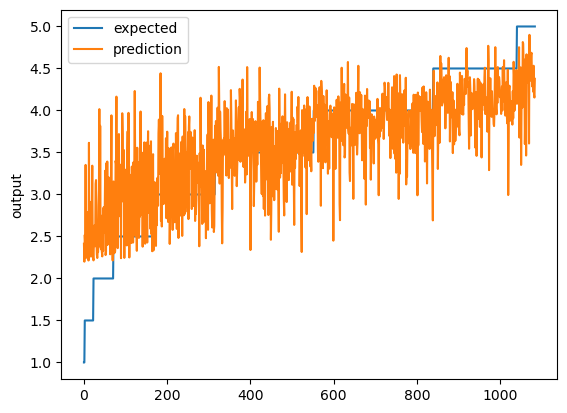

In [36]:
# Finding the Best Model:
# Testing with:
# Activation: relu, sigmoid, tanh 
# Number of layers and neuron count for each layer 
# Optimizer: adam and sgd.

from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers


model_dir = "models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Set path and preprocess for functions
path = "./yelp_dataset/"

#Set paths for JSON
review_Path = os.path.join(path,"yelp_academic_dataset_review.json")
business_Path = os.path.join(path,"yelp_academic_dataset_business.json")

# Read JSON data and drop businesses with less than 20 reviews
review_df = pd.read_json(review_Path, lines=True, nrows = 100000)
all_business_df = pd.read_json(business_Path, lines=True, nrows = 100000)
business_df = all_business_df[all_business_df['review_count'] >= 20]

#You may use the following code to group ALL the reviews by each business and create a new
#dataframe, where each line is a business with all its reviews aggregated together. From there,
#you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

#Create table with ID, stars, and all reviews in one table then change 'stars' since this is already a col on tfidf
business_subset = business_df[['business_id', 'stars']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, df_ready_to_be_sent_to_sklearn, on='business_id', how='inner')
merged_df.rename(columns={'stars': 'stars_for_model'}, inplace=True)

# Initialize the tfidf Vectorizer and set max features and stop words
tfidf = TfidfVectorizer(max_features=4000,stop_words="english")

# Transform all_reviews and turn into a matrix
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Turn the matrix into a dataframe where the cols are all the words. Then add the stars into the dataframe for model to use and use to_xy for tensorflow to read
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df = pd.concat([merged_df['stars_for_model'], tfidf_df] , axis=1)
x,y = to_xy(tfidf_df,'stars_for_model')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Define hyperparameters that were requested
activations = ['relu', 'sigmoid', 'tanh']
layer_neurons = [[100, 50], [100, 50, 25], [150, 75, 30], [100, 100, 100], [150, 100, 75, 50, 25]]  # Different layer configurations
optimizers = ['adam', 'sgd']

def Model_Test(activation, layer_neurons, optimizer):
    model = Sequential()
    model.add(Dense(layer_neurons[0], input_dim=x_train.shape[1], activation=activation))
    model.add(Dropout(0.1))
    for n in layer_neurons[1:]:
        model.add(Dense(n, activation=activation))
        model.add(Dropout(0.1))
    model.add(Dense(1, activation ='linear'))
    model.compile(loss='mean_squared_error', optimizer = optimizer)
    return model

best_rmse = float('inf')
best_model = None
best_params = {}

results = []

for activation in activations:
    for neurons in layer_neurons:
        for optimizer in optimizers:
            model = Model_Test(activation, neurons, optimizer)

            #
            monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
            model_filename = f"model_{activation}_{neurons}_{optimizer}.keras"
            checkpointer = ModelCheckpoint(filepath=model_filename, verbose=0, save_best_only=True) # save best model

            # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
            model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 32, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)

            #
            model.load_weights(model_filename)

            # Predict and measure RMSE
            pred = model.predict(x_test)
            print(pred)
            score = np.sqrt(metrics.mean_squared_error(pred,y_test))
            print("Score (RMSE): {}".format(score))

            # Store results
            results.append({
                'Activation': activation,
                'Neurons': str(neurons),
                'Optimizer': optimizer,
                'RMSE': score
            })

            if score < best_rmse:
                best_rmse = score
                best_model = model
                best_params = {
                    'Activation': activation,
                    'Neurons': neurons,
                    'Optimizer': optimizer,
                    'RMSE': best_rmse
                }

# Table of Results
results_df = pd.DataFrame(results)
print(results_df)

print("\nBest Combination:")
print(best_params)

# Plot the chart without Rounding & RMSE
pred = best_model.predict(x_test)

score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE) without Rounding: {}".format(score))
chart_regression(pred.flatten(), y_test)

# Displaying 5 Businesses Randomly

# Merged df to connect business names back to the star ratings
merged_name_star = pd.merge(business_names, merged_df, on='business_id', how='inner')
businesses = merged_name_star['name']
b_id = merged_name_star['business_id']

# Specific data prediction for 5 businesses
for i in range(5):
    j = random.randint(0, (y_test.size) - 1)
    print("{}. {} {}: rating: {}, predicted rating: {}".format(j+1, businesses[j], b_id[j], y_test[j], pred[j]))

Score (RMSE) with Rounding: 0.5527939796447754


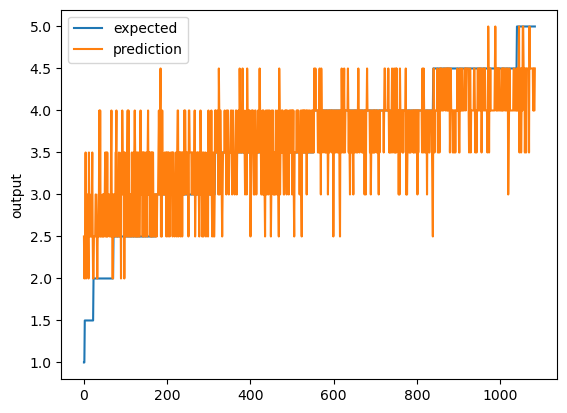

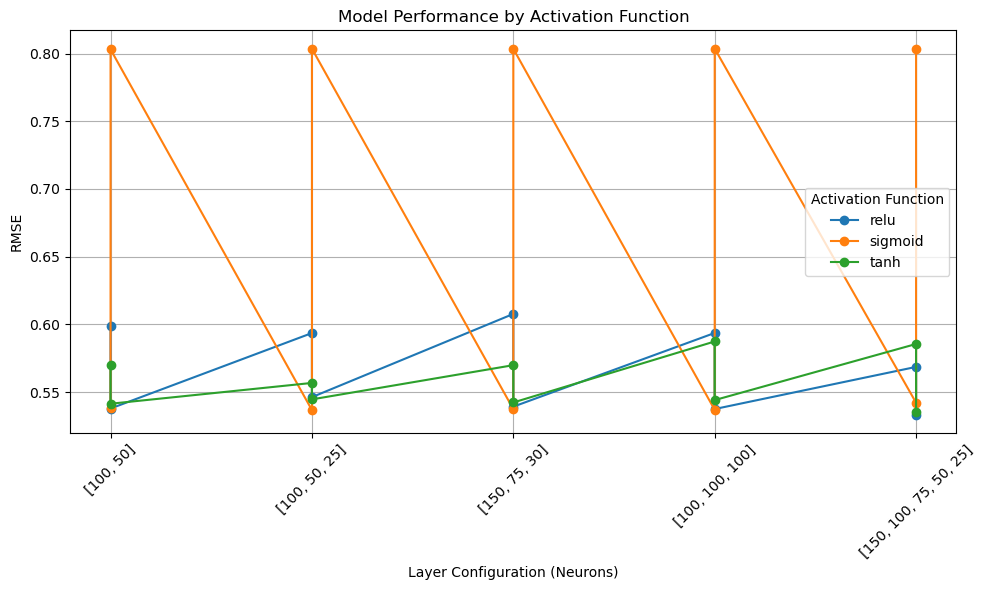

In [38]:

# Rounding up predicted values to .5
for i in pred:
    if i[0] < 5:
        i[0] = round(i[0]*2)/2
    if i[0] > 5:
        i[0] = 5

# Plot the chart with Rounding & RMSE
score2 = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE) with Rounding: {}".format(score2))
chart_regression(pred.flatten(), y_test)

plot(results_df)

### Additional Feature: Different Review Counts
- This tests if changing the minimum review count for a business to qualify would change the RMSE
- Conclusion: Excluding businesses with less reviews lends to a better Model, with a lower RMSE

REG
Epoch 1/1000


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 - 3s - 66ms/step - loss: 3.4938 - val_loss: 1.1511
Epoch 2/1000
52/52 - 0s - 8ms/step - loss: 0.6948 - val_loss: 0.5587
Epoch 3/1000
52/52 - 0s - 7ms/step - loss: 0.3482 - val_loss: 0.3975
Epoch 4/1000
52/52 - 0s - 7ms/step - loss: 0.2186 - val_loss: 0.3640
Epoch 5/1000
52/52 - 0s - 7ms/step - loss: 0.1659 - val_loss: 0.3413
Epoch 6/1000
52/52 - 0s - 7ms/step - loss: 0.1505 - val_loss: 0.4291
Epoch 7/1000
52/52 - 0s - 7ms/step - loss: 0.1300 - val_loss: 0.3284
Epoch 8/1000
52/52 - 0s - 7ms/step - loss: 0.1087 - val_loss: 0.3256
Epoch 9/1000
52/52 - 0s - 7ms/step - loss: 0.1024 - val_loss: 0.3185
Epoch 10/1000
52/52 - 0s - 7ms/step - loss: 0.0931 - val_loss: 0.3020
Epoch 11/1000
52/52 - 0s - 6ms/step - loss: 0.0942 - val_loss: 0.3038
Epoch 12/1000
52/52 - 0s - 6ms/step - loss: 0.0878 - val_loss: 0.3287
Epoch 13/1000
52/52 - 0s - 6ms/step - loss: 0.0767 - val_loss: 0.3039
Epoch 14/1000
52/52 - 0s - 6ms/step - loss: 0.0754 - val_loss: 0.3099
Epoch 15/1000
52/52 - 1s - 12ms/step - lo

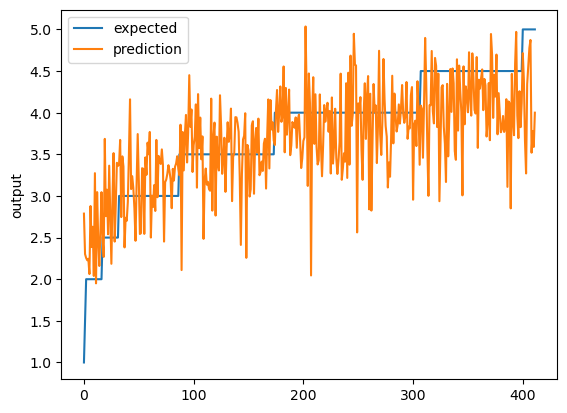

In [70]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

# Changing Minimum Review Count to 70

# Set path and preprocess for functions
path = "./yelp_dataset/"
preprocess = True

#Set paths for JSON
review_Path = os.path.join(path,"yelp_academic_dataset_review.json")
business_Path = os.path.join(path,"yelp_academic_dataset_business.json")

# Read JSON data and drop businesses with less than 70 reviews
review_df = pd.read_json(review_Path, lines=True, nrows = 100000)
all_business_df = pd.read_json(business_Path, lines=True, nrows = 100000)
business_df = all_business_df[all_business_df['review_count'] >= 70]

#You may use the following code to group ALL the reviews by each business and create a new
#dataframe, where each line is a business with all its reviews aggregated together. From there,
#you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

#Create table with ID, stars, and all reviews in one table then change 'stars' since this is already a col on tfidf
business_subset = business_df[['business_id', 'stars']]
business_names = business_df[['name', 'business_id']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, review_subset, on='business_id', how='inner')
merged_df.rename(columns={'stars': 'stars_for_model'}, inplace=True)

# Initialize the tfidf Vectorizer and set max features and stop words
tfidf = TfidfVectorizer(max_features=4000,stop_words="english")

# Transform all_reviews and turn into a matrix
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Turn the matrix into a dataframe where the cols are all the words. Then add the stars into the dataframe for model to use and use to_xy for tensorflow to read
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df = pd.concat([merged_df['stars_for_model'], tfidf_df] , axis=1)
x,y = to_xy(tfidf_df,'stars_for_model')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

#Run the model 5 times to ensure best model is found
i = 0
while (i < 5):
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) 
    model.add(Dropout(0.1))
    model.add(Dense(25, input_dim=x.shape[1], activation='relu')) 
    model.add(Dense(1, activation='linear'))

    adam = optimizers.Adam(learning_rate=0.001, beta_1=0.999, beta_2=0.999, epsilon=None, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="dnn/yelp.keras", verbose=0, save_best_only=True) # save best model

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
    model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size= 32, callbacks=[monitor,checkpointer], verbose=2, epochs=1000)
    i = i+1

model.load_weights('dnn/yelp.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Merged df to connect business names back to the star ratings
merged_name_star = pd.merge(business_names, merged_df, on='business_id', how='inner')
businesses = merged_name_star['name']
b_id = merged_name_star['business_id']

# Specific data prediction for 5 businesses
for i in range(5):
    j = random.randint(0, (y_test.size) - 1)
    print("{}. {} {}: rating: {}, predicted rating: {}".format(j+1, businesses[j], b_id[j], y_test[j], pred[j]))

# Plot the chart
chart_regression(pred.flatten(),y_test)


REG


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
49/49 - 3s - 71ms/step - loss: 6.8222 - val_loss: 1.3106
Epoch 2/1000
49/49 - 0s - 8ms/step - loss: 1.1294 - val_loss: 0.7682
Epoch 3/1000
49/49 - 0s - 9ms/step - loss: 0.5945 - val_loss: 0.4509
Epoch 4/1000
49/49 - 0s - 9ms/step - loss: 0.3238 - val_loss: 0.3128
Epoch 5/1000
49/49 - 0s - 7ms/step - loss: 0.2074 - val_loss: 0.2931
Epoch 6/1000
49/49 - 0s - 6ms/step - loss: 0.1812 - val_loss: 0.3325
Epoch 7/1000
49/49 - 0s - 6ms/step - loss: 0.1411 - val_loss: 0.2839
Epoch 8/1000
49/49 - 0s - 6ms/step - loss: 0.1201 - val_loss: 0.2846
Epoch 9/1000
49/49 - 0s - 5ms/step - loss: 0.1112 - val_loss: 0.3529
Epoch 10/1000
49/49 - 0s - 6ms/step - loss: 0.1025 - val_loss: 0.3163
Epoch 11/1000
49/49 - 0s - 7ms/step - loss: 0.0849 - val_loss: 0.3089
Epoch 12/1000
49/49 - 0s - 8ms/step - loss: 0.0854 - val_loss: 0.2938
Epoch 13/1000
49/49 - 0s - 8ms/step - loss: 0.0807 - val_loss: 0.2974
Epoch 14/1000
49/49 - 0s - 6ms/step - loss: 0.0749 - val_loss: 0.3154
Epoch 15/1000
49/49 - 0s - 6

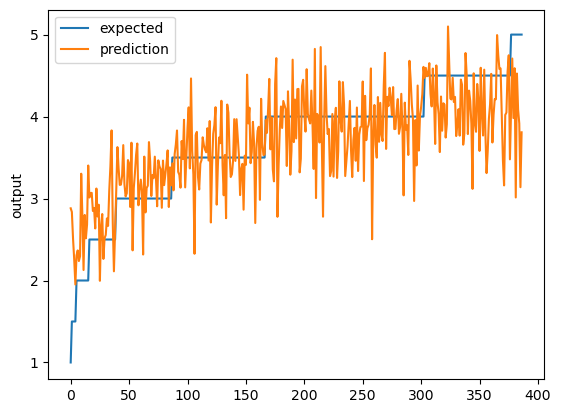

In [71]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

# Changing Minimum Review Count to 75

# Set path and preprocess for functions
path = "./yelp_dataset/"
preprocess = True

#Set paths for JSON
review_Path = os.path.join(path,"yelp_academic_dataset_review.json")
business_Path = os.path.join(path,"yelp_academic_dataset_business.json")

# Read JSON data and drop businesses with less than 75 reviews
review_df = pd.read_json(review_Path, lines=True, nrows = 100000)
all_business_df = pd.read_json(business_Path, lines=True, nrows = 100000)
business_df = all_business_df[all_business_df['review_count'] >= 75]

#You may use the following code to group ALL the reviews by each business and create a new
#dataframe, where each line is a business with all its reviews aggregated together. From there,
#you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

#Create table with ID, stars, and all reviews in one table then change 'stars' since this is already a col on tfidf
business_subset = business_df[['business_id', 'stars']]
business_names = business_df[['name', 'business_id']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, review_subset, on='business_id', how='inner')
merged_df.rename(columns={'stars': 'stars_for_model'}, inplace=True)

# Initialize the tfidf Vectorizer and set max features and stop words
tfidf = TfidfVectorizer(max_features=4000,stop_words="english")

# Transform all_reviews and turn into a matrix
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Turn the matrix into a dataframe where the cols are all the words. Then add the stars into the dataframe for model to use and use to_xy for tensorflow to read
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df = pd.concat([merged_df['stars_for_model'], tfidf_df] , axis=1)
x,y = to_xy(tfidf_df,'stars_for_model')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

#Run the model 5 times to ensure best model is found
i = 0
while (i < 5):
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) 
    model.add(Dropout(0.1))
    model.add(Dense(25, input_dim=x.shape[1], activation='relu')) 
    model.add(Dense(1, activation='linear'))

    adam = optimizers.Adam(learning_rate=0.001, beta_1=0.999, beta_2=0.999, epsilon=None, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="dnn/yelp.keras", verbose=0, save_best_only=True) # save best model

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
    model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size= 32, callbacks=[monitor,checkpointer], verbose=2, epochs=1000)
    i = i+1

model.load_weights('dnn/yelp.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE): {}".format(score))

# Merged df to connect business names back to the star ratings
merged_name_star = pd.merge(business_names, merged_df, on='business_id', how='inner')
businesses = merged_name_star['name']
b_id = merged_name_star['business_id']

for i in range(5):
    j = random.randint(0, (y_test.size) - 1)
    print("{}. {} {}: rating: {}, predicted rating: {}".format(j+1, businesses[j], b_id[j], y_test[j], pred[j]))

# Plot the chart
chart_regression(pred.flatten(), y_test)


### Additional Feature: Per Category Model
- Groups Businesses by a specified category and creates a model with the affected businesses
- Conclusion: Placing into categories limits the training data and produces a less accurate RMSE

In [72]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

# Per Category 
ctgry = 'Mexican'


# Read JSON data and drop businesses with less than 20 reviews
review_df = pd.read_json(review_Path, lines=True, nrows = 100000)
all_business_df_0 = pd.read_json(business_Path, lines=True, nrows = 100000)
b_id = all_business_df[['business_id']]


# Filter to specific category
all_business_df = all_business_df_0[all_business_df_0['categories'].astype(str).str.contains(ctgry)]
print(all_business_df)

# Filter our businesses with less than 20 reviews
business_df = all_business_df[all_business_df['review_count'] >= 50]

#You may use the following code to group ALL the reviews by each business and create a new
#dataframe, where each line is a business with all its reviews aggregated together. From there,
#you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

#Create table with ID, stars, and all reviews in one table then change 'stars' since this is already a col on tfidf
business_subset = business_df[['business_id', 'stars']]
business_names = business_df[['name', 'business_id']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, review_subset, on='business_id', how='inner')
merged_df.rename(columns={'stars': 'stars_for_model'}, inplace=True)

# Initialize the tfidf Vectorizer and set max features and stop words
tfidf = TfidfVectorizer(max_features=4000,stop_words="english")

# Transform all_reviews and turn into a matrix
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Turn the matrix into a dataframe where the cols are all the words. Then add the stars into the dataframe for model to use and use to_xy for tensorflow to read
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df = pd.concat([merged_df['stars_for_model'], tfidf_df] , axis=1)
x,y = to_xy(tfidf_df,'stars_for_model')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

#Run the model 5 times to ensure best model is found
i = 0
while (i < 5):
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) 
    model.add(Dropout(0.1))
    model.add(Dense(25, input_dim=x.shape[1], activation='relu')) 
    model.add(Dense(1, activation='linear'))

    adam = optimizers.Adam(learning_rate=0.001, beta_1=0.999, beta_2=0.999, epsilon=None, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="dnn/yelp.keras", verbose=0, save_best_only=True) # save best model

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
    model.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size= 32, callbacks=[monitor,checkpointer], verbose=2, epochs=1000)
    i = i+1

model.load_weights('dnn/yelp.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE) wihtout Rounding: {}".format(score))

# Merged df to connect business names back to the star ratings
merged_name_star = pd.merge(business_names, merged_df, on='business_id', how='inner')
businesses = merged_name_star['name']
b_id = merged_name_star['business_id']

# Specific data prediction for 5 businesses
for i in range(5):
    j = random.randint(0, (y_test.size) - 1)
    print("{}. {} {}: rating: {}, predicted rating: {}".format(j+1, businesses[j], b_id[j], y_test[j], pred[j]))

# Rounding up predicted values to .5
for i in pred:
    if i[0] < 5:
        i[0] = round(i[0]*2)/2 

score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE) with Rounding: {}".format(score))

# Plot the chart
chart_regression(pred.flatten(), y_test)


                  business_id                    name               address  \
104    Dy91wdWkwtI_qgjAIZ0Niw     Taqueria Los Primos  3322 Old Capitol Trl   
153    aNtKyc2rr-uK5cqzY9TVQQ  Chipotle Mexican Grill     10160 Ulmerton Rd   
159    X_E7U2lVNEwbH_gpOBmAHQ          Cerveza Jack's         135 2nd Ave N   
278    W57cR9a7XP6RX56MSWHJJA          Las Margaritas      514 S Rampart St   
290    xa6JYHDgVza7CuenKBJBHw       Taqueria El Sitio   3466 A Lebanon Pike   
...                       ...                     ...                   ...   
99919  4E6kHJ7yxDpu43L8he6F7A      La Casita Taqueria           8400 Oak St   
99926  lWnqWDfcISTHnL973Uwplg    Mariscos Las Islitas      1700 S Wells Ave   
99953  vHys_KQJys2bSO2w1_WHrg         Los Tacos Locos         119 S York Rd   
99989  lkAzVdzEZE0jEU91PmvQhQ        Margaritas Grill  3320 Old Capitol Trl   
99993  Z2_-rlxyXQsqcGXChydhlA  La Guera Mexican Grill        132 Garrett Rd   

              city state postal_code   latitude   l

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 - 3s - 505ms/step - loss: 13.0933 - val_loss: 11.4350
Epoch 2/1000
5/5 - 0s - 26ms/step - loss: 10.5053 - val_loss: 8.2741
Epoch 3/1000
5/5 - 0s - 30ms/step - loss: 6.7990 - val_loss: 4.2515
Epoch 4/1000
5/5 - 0s - 30ms/step - loss: 2.9520 - val_loss: 1.2931
Epoch 5/1000
5/5 - 0s - 20ms/step - loss: 1.5606 - val_loss: 1.7387
Epoch 6/1000
5/5 - 0s - 18ms/step - loss: 2.0919 - val_loss: 1.4800
Epoch 7/1000
5/5 - 0s - 28ms/step - loss: 1.3554 - val_loss: 0.9712
Epoch 8/1000
5/5 - 0s - 21ms/step - loss: 0.9446 - val_loss: 1.0785
Epoch 9/1000
5/5 - 0s - 28ms/step - loss: 1.1321 - val_loss: 1.0214
Epoch 10/1000
5/5 - 0s - 30ms/step - loss: 0.8635 - val_loss: 0.8254
Epoch 11/1000
5/5 - 0s - 29ms/step - loss: 0.7582 - val_loss: 0.8121
Epoch 12/1000
5/5 - 0s - 38ms/step - loss: 0.6265 - val_loss: 0.7694
Epoch 13/1000
5/5 - 0s - 60ms/step - loss: 0.4655 - val_loss: 0.6830
Epoch 14/1000
5/5 - 0s - 40ms/step - loss: 0.4336 - val_loss: 0.6625
Epoch 15/1000
5/5 - 0s - 41ms/step - loss: 0.3378 - 